# Projet 7

In [8]:
import time

start_notebook = time.time()

In [9]:
# Zone installation packages :
#%pip install pandas numpy matplotlib seaborn missingno plotly
#%pip install emoji

___
## Command Git

- echo "# OC_AI_Engineer_P7" >> README.md
- git init
- git add README.md
- git commit -m "Mise à jour du notebook"
- git branch -M main
- git remote add origin https://github.com/AnthonyJVID/OC_AI_Engineer_P7.git
- git push -u origin main/master
- git log (("q") pour sortir) affiche les commits
___
#### Vérification des commandes
- **git remote** - Vérifie le dépot
- **git add** - ajoute des fichier au suivi
- **git commit** -m "Message des modifications" - Crée un commit
- **git push origin main/master** - Pousse les modification sur Github

## Command MLFlow
mlflow server \
--backend-store-uri sqlite:///C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/OC_AI_Engineer_P7/mlflow\
--default-artifact-root file:///C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/OC_AI_Engineer_P7/mlruns\
--host 127.0.0.1 \
--port 5000

In [10]:
# Importation des librairies
import sys
import os
import re
import string
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly
import plotly.express as px
import nltk
import mlflow
import mlflow.sklearn
import emoji
import tensorflow_hub as hub
import tensorflow as tf
import logging
import fasttext.util



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import FastText
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Dropout, GRU
from keras.layers import GlobalMaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from plot_keras_history import show_history, plot_history
from transformers import BertTokenizer, TFBertForSequenceClassification, TFAutoModel, AutoTokenizer
from mlflow.models.signature import infer_signature



# URI de suivi vers le serveur MLflow (local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Vérification si l'expérience existe
experiment = mlflow.get_experiment_by_name("OC_Project7")
if experiment is None:
    experiment_id = mlflow.create_experiment("OC_Project7")
else:
    experiment_id = experiment.experiment_id



nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")



# Réduire les avertissements liées a TF
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
# Information sur l'environnement virtuel :
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Matplotlib    : " + matplotlib.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)
print("plotly        : " + plotly.__version__)
print("Tensorflow    : " + tf.__version__)
print("Tensorflow_hub: " + hub.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 1.26.4
Matplotlib    : 3.10.0
Seaborn       : 0.13.2
missingno     : 0.5.2
plotly        : 5.24.1
Tensorflow    : 2.18.0
Tensorflow_hub: 0.16.1


In [12]:
# Paramètre d'affichage :
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# style de titres
style = {"family": "Georgia",
        "color":  "darkblue",
        "weight": "bold",
        "size": 15,
        }

## Fonctions Utilitaires

In [13]:
def clean_text(text):
    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer les URLs et les mentions
    text = re.sub(r"https?://\S+|www\.\S+|@\w+", " ", text)

    # Remplacer les emojis par leur signification
    text = emoji.demojize(text)

    # Supprimer les hashtags tout en gardant leur contenu
    text = re.sub(r"#(\w+)", r"\1", text)

    # Supprimer les chiffres et les ponctuations
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)

    # Supprimer les répétitions excessives de caractères
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # Tokeniser et supprimer les stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoindre les mots nettoyés
    cleaned_text = " ".join(tokens)

    return cleaned_text

def old_clean_text(text):
    # Convertir le texte en minuscules
    text = str(text).lower()

    # Supprimer les chiffres, les balises HTML et les liens URL
    text = re.sub(r"\d+|\[.*?\]|https?://\S+|www\.\S+", " ", text)

    # Supprimer les emojis et les symboles divers
    text = re.sub(r"["
                u"\U0001F600-\U0001F64F"   # Emoticônes
                u"\U0001F300-\U0001F5FF"   # Symboles et pictogrammes
                u"\U0001F680-\U0001F6FF"   # Symboles de transport/cartes
                u"\U0001F1E0-\U0001F1FF"   # Drapeaux (iOS)
                u"\u200d"                  # Jointure à largeur zéro
                u"\u2640-\u2642"           # Symboles de genre
                u"\U000024C2-\U0001F251"   # Caractères enfermés
                "]+", " ", text)

    # Tokeniser le texte
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoindre les tokens nettoyés
    cleaned_text = " ".join(tokens)

    return cleaned_text

def wordcloud(tweets, titre):
    tout_texte = " ".join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(titre, fontsize=14)
    plt.axis("off")
    plt.show()

def load_glove_embeddings(chemin_fichier):
    embeddings_index = {}
    with open(chemin_fichier, "r", encoding="utf8") as f:
        for ligne in f:
            valeurs = ligne.split()
            mot = valeurs[0]
            vecteur = np.asarray(valeurs[1:], dtype="float32")
            embeddings_index[mot] = vecteur
    return embeddings_index

# Ajustement en fonction du choix
chemin_glove_25 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.25d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_25)

chemin_glove_50 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.50d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_50)

chemin_glove_100 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.100d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_100)

chemin_glove_200 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_200)

def load_fasttext_embeddings(chemin_fichier):
    embeddings_index = {}
    with open(chemin_fichier, "r", encoding="utf8") as f:
        # La première ligne peut contenir la taille du vocabulaire et la dimension
        premiere_ligne = True
        for ligne in f:
            if premiere_ligne:
                premiere_ligne = False
                continue
            valeurs = ligne.rstrip().split(" ")
            mot = valeurs[0]
            vecteur = np.asarray(valeurs[1:], dtype="float32")
            embeddings_index[mot] = vecteur
    return embeddings_index

def train_evaluate_simple_model(run_name, model, X_train_vec, y_train, X_val_vec, y_val):
    model_name = type(model).__name__

    # Initialisation d'un run avec le nom donné
    with mlflow.start_run(run_name=run_name):
        # Entraînement du modèle
        model.fit(X_train_vec, y_train)

        # Prédiction et évaluation du modèle sur l'ensemble de validation
        y_val_pred = model.predict(X_val_vec)
        accuracy_val = accuracy_score(y_val, y_val_pred)
        recall_val = recall_score(y_val, y_val_pred, average="weighted")
        f1_val = f1_score(y_val, y_val_pred, average="weighted")
        auc_val = roc_auc_score(y_val, y_val_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        specificity_val = tn / (tn+fp)

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        # Prédiction et évaluation du modèle sur l'ensemble de test
        y_test_pred = model.predict(X_test_vec)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred, average="weighted")
        f1_test = f1_score(y_test, y_test_pred, average="weighted")
        auc_test = roc_auc_score(y_test, y_test_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        specificity_test = tn / (tn+fp)

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)


        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, model_name)
        mlflow.end_run()

def train_evaluate_neural_model(name_exp, run_name, model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()["name"])

        # Création du callback
        model_save_path = "model_best_weights.keras"
        checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_pad, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_pad, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_pad, y_test, verbose=True)
        print("Validation Accuracy:  {:.4f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_pad, y_val, verbose=False)
        print("Validation Accuracy :  {:.4f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_pad) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_pad) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_pad) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_pad)
        recall_test = recall_score(y_test, y_pred_test, average="weighted")
        f1_test = f1_score(y_test, y_pred_test, average="weighted")
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f"Accuracy: {accuracy_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        print(f"AUC: {auc_test}")
        print(f"Specificity: {specificity_test}")

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_pad)
        recall_val = recall_score(y_val, y_pred_val, average="weighted")
        f1_val = f1_score(y_val, y_pred_val, average="weighted")
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f"Accuracy: {accuracy_val}")
        print(f"Recall: {recall_val}")
        print(f"F1 Score: {f1_val}")
        print(f"AUC: {auc_val}")
        print(f"Specificity: {specificity_val}")

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                            add_special_tokens = True,
                                            max_length = max_length,
                                            padding="max_length",
                                            return_attention_mask = True,
                                            return_token_type_ids=True,
                                            truncation=True,
                                            return_tensors="tf")

        input_ids.append(bert_inp["input_ids"][0])
        token_type_ids.append(bert_inp["token_type_ids"][0])
        attention_mask.append(bert_inp["attention_mask"][0])
        bert_inp_tot.append((bert_inp["input_ids"][0],
                            bert_inp["token_type_ids"][0],
                            bert_inp["attention_mask"][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode="HF") :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    last_hidden_states_tot = None

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                    bert_tokenizer, max_length)

        if mode=="HF" :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=="TFhub" : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                "input_mask" : attention_mask,
                                "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs["sequence_output"]

        if last_hidden_states_tot is None :
            last_hidden_states_tot = last_hidden_states
        elif last_hidden_states.ndim > 0 and last_hidden_states_tot.ndim > 0:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    if last_hidden_states_tot is not None:
        features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    else:
        features_bert = None

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

def train_evaluate_BERT_model(name_exp, run_name, model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()["name"])

        # Création du callback
        model_save_path = "model_best_weights.keras"
        checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_bert, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_bert, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_bert, y_train, verbose=True)
        print("Training Accuracy: {:.2f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_bert, y_test, verbose=True)
        print("Validation Accuracy:  {:.2f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_bert, y_val, verbose=False)
        print("Validation Accuracy :  {:.2f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_bert) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_bert) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_bert) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_bert)
        recall_test = recall_score(y_test, y_pred_test, average="weighted")
        f1_test = f1_score(y_test, y_pred_test, average="weighted")
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f"Accuracy: {accuracy_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        print(f"AUC: {auc_test}")
        print(f"Specificity: {specificity_test}")

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_bert)
        recall_val = recall_score(y_val, y_pred_val, average="weighted")
        f1_val = f1_score(y_val, y_pred_val, average="weighted")
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f"Accuracy: {accuracy_val}")
        print(f"Recall: {recall_val}")
        print(f"F1 Score: {f1_val}")
        print(f"AUC: {auc_val}")
        print(f"Specificity: {specificity_val}")

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

def process_text(doc: str,
                rejoin: bool = False,
                lemm_or_stemm: str = None,  # "lem", "stem", ou None
                list_rare_words: list = None,
                min_len_word: int = 0,
                force_is_alpha: bool = True,
                eng_words: set = None,
                remove_words: set = None,
                include_stopwords: bool = True,
                lowercase: bool = True) -> str:

    # Initialisation
    if not isinstance(doc, str):
        raise ValueError("L'entrée 'doc' doit être une chaîne de caractères.")

    if lemm_or_stemm not in [None, "lem", "stem"]:
        raise ValueError("La valeur de 'lemm_or_stemm' doit être 'lem', 'stem' ou None.")

    # Liste des mots rares par défaut
    list_rare_words = list_rare_words or []

    # Conversion en minuscules
    doc = doc.lower().strip() if lowercase else doc.strip()

    # Tokenisation
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Stopwords
    stop_words = set(stopwords.words("english"))
    if include_stopwords:
        cleaned_tokens_list = raw_tokens_list  # Inclure tous les mots
    else:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Exclusion des mots rares
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]

    # Exclusion des mots spécifiques
    if remove_words:
        non_rare_tokens = [w for w in non_rare_tokens if w not in remove_words]

    # Filtrer par longueur minimale
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Garder uniquement les mots alphabétiques
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    # Lemmatisation ou stemming
    if lemm_or_stemm == "lem":
        lemmatizer = WordNetLemmatizer()
        trans_text = [lemmatizer.lemmatize(w) for w in alpha_tokens]
    elif lemm_or_stemm == "stem":
        stemmer = PorterStemmer()
        trans_text = [stemmer.stem(w) for w in alpha_tokens]
    else:
        trans_text = alpha_tokens

    # Filtrer par mots valides en anglais
    if eng_words:
        engl_text = [w for w in trans_text if w in eng_words]
    else:
        engl_text = trans_text

    # Retour sous forme de chaîne ou de liste
    return " ".join(engl_text) if rejoin else engl_text

# Importation des données

In [14]:
data = pd.read_csv("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/tweets.csv", sep=",", encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

## Exploration des données

In [15]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [16]:
data.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [18]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1600000
Nombre de colonnes : 6
Type des colonnes : 
object    4
int64     2
Name: count, dtype: int64


In [19]:
data.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [20]:
data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

<Axes: >

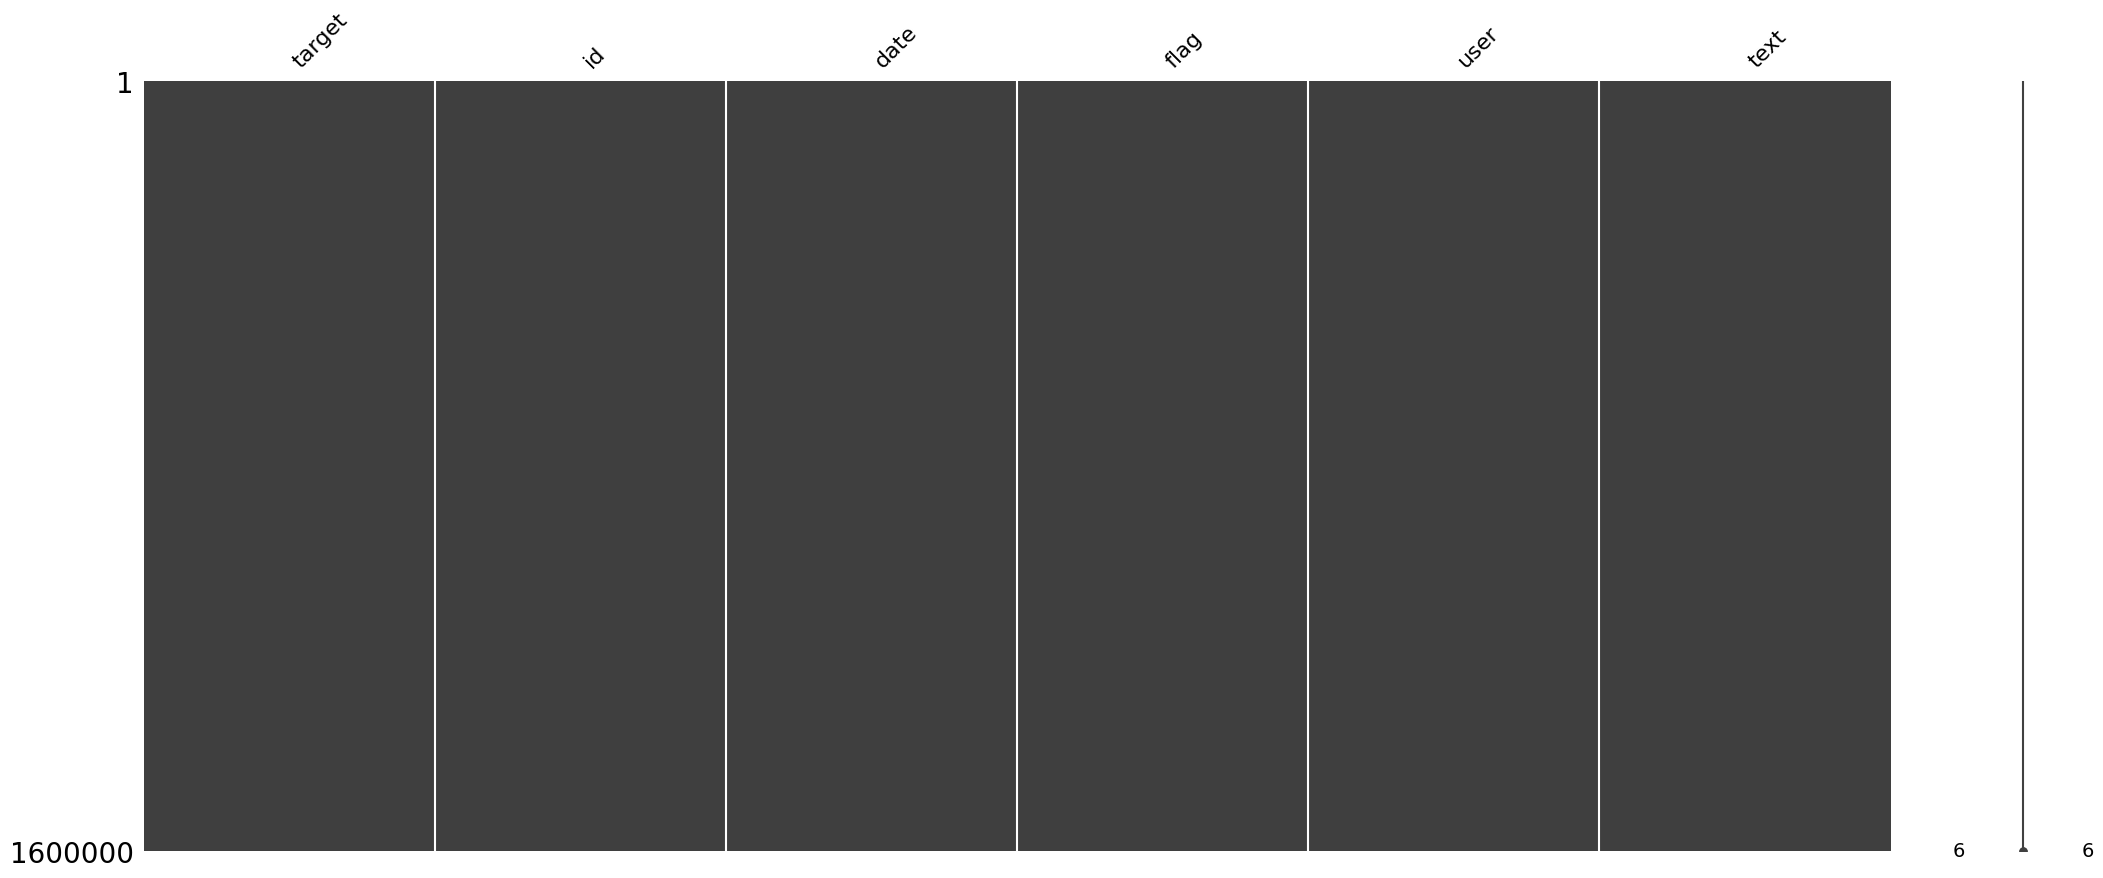

In [21]:
msno.matrix(data)

### Target

In [22]:
# Observation des valeurs de la colonne Target
unique_values = data["target"].unique()
print(unique_values)

[0 4]


In [23]:
# Répartition des valeurs
value_counts = data["target"].value_counts()
print(value_counts)

target
0    800000
4    800000
Name: count, dtype: int64


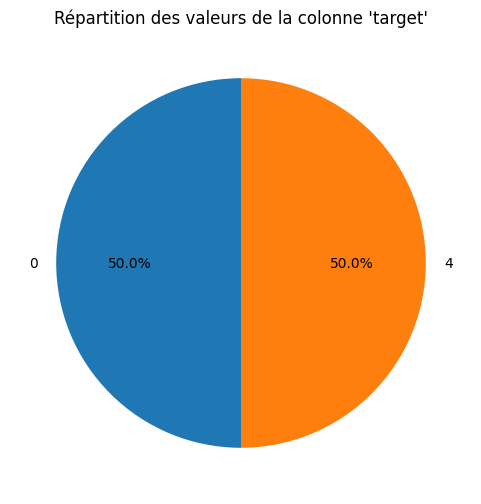

In [24]:
# Vue graphique
value_counts_graph = data["target"].value_counts()

value_counts_graph.plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(6, 6))
plt.title("Répartition des valeurs de la colonne 'target'")
plt.ylabel("")
plt.show()

In [25]:
data.loc[data["target"] == 4, "target"] = 1
data.target.unique()

array([0, 1], dtype=int64)

### ID

In [26]:
print(data["id"].duplicated().sum())

1685


In [27]:
doublons = data[data["id"].duplicated()]
print(doublons)

         target          id                          date      flag  \
800261        1  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY   
800300        1  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY   
801280        1  1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   
801573        1  1468100580  Mon Apr 06 23:42:57 PDT 2009  NO_QUERY   
801650        1  1468115720  Mon Apr 06 23:48:00 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1598780       1  2193278017  Tue Jun 16 08:14:22 PDT 2009  NO_QUERY   
1599298       1  2193403830  Tue Jun 16 08:24:44 PDT 2009  NO_QUERY   
1599385       1  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY   
1599440       1  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY   
1599931       1  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY   

                 user                                               text  
800261       DjGundam  Awwh babs... you look so sad underneith that s...

In [28]:
ids_dupliques = data["id"][data["id"].duplicated()]
print(ids_dupliques.unique())

[1467863684 1467880442 1468053611 ... 2193428118 2193451289 2193576442]


### Flag

In [29]:
unique_values = data["flag"].unique()
print(unique_values)

['NO_QUERY']


### Text

In [30]:
# Aperçu de la Target 0
ligne_target_0 = data[data["target"] == 0].iloc[799999]

print("Ligne avec target = 0 :")
print(ligne_target_0)


Ligne avec target = 0 :
target                                                    0
id                                               2329205794
date                           Thu Jun 25 10:28:31 PDT 2009
flag                                               NO_QUERY
user                                             tpchandler
text      has to resit exams over summer...  wishes he w...
Name: 799999, dtype: object


In [31]:
# Aperçu de la Target 4
ligne_target_1 = data[data["target"] == 1].iloc[0]

print("\nLigne avec target = 1 :")
print(ligne_target_1)


Ligne avec target = 1 :
target                                               1
id                                          1467822272
date                      Mon Apr 06 22:22:45 PDT 2009
flag                                          NO_QUERY
user                                             ersle
text      I LOVE @Health4UandPets u guys r the best!! 
Name: 800000, dtype: object


# Prétraitement

In [32]:
tweets_positifs = data[data["target"] == 1].sample(n=16000, random_state=77)

tweets_negatifs = data[data["target"] == 0].sample(n=16000, random_state=77)

df_tweets = pd.concat([tweets_positifs, tweets_negatifs])
df_tweets = df_tweets.reset_index(drop=True)
df_tweets

,target,id,date,flag,user,text
0,1,2175633751,Mon Jun 15 01:32:47 PDT 2009,NO_QUERY,Nessa2813,Listening/singing along to Taylor Swift while ...
1,1,1831959940,Sun May 17 19:51:47 PDT 2009,NO_QUERY,chopsoi,best sentence ever... &quot; i wish i'd been b...
2,1,1833823364,Mon May 18 00:35:05 PDT 2009,NO_QUERY,tigeladakawaii,Thanks @ttimechitchat ? http://blip.fm/~6im45
3,1,2015231983,Wed Jun 03 04:05:19 PDT 2009,NO_QUERY,dit53,"Good game so far , let's see what the second h..."
4,1,1678605865,Sat May 02 07:13:11 PDT 2009,NO_QUERY,binilvarghese,It's official now ! ! ! Scary yet feels good
...,...,...,...,...,...,...
31995,0,2213662162,Wed Jun 17 15:40:32 PDT 2009,NO_QUERY,MaxxAzria,my tummy hurts and i still have to do my h.w....
31996,0,2329173512,Thu Jun 25 10:26:13 PDT 2009,NO_QUERY,FirstLadyCfrank,"@houstonbeauty yea,not til September"
31997,0,2177497240,Mon Jun 15 06:12:37 PDT 2009,NO_QUERY,dohtay,Have to go to school today Need extra help in...
31998,0,2325621402,Thu Jun 25 05:47:01 PDT 2009,NO_QUERY,Shameez,My boys is never staying at home again.Last ti...


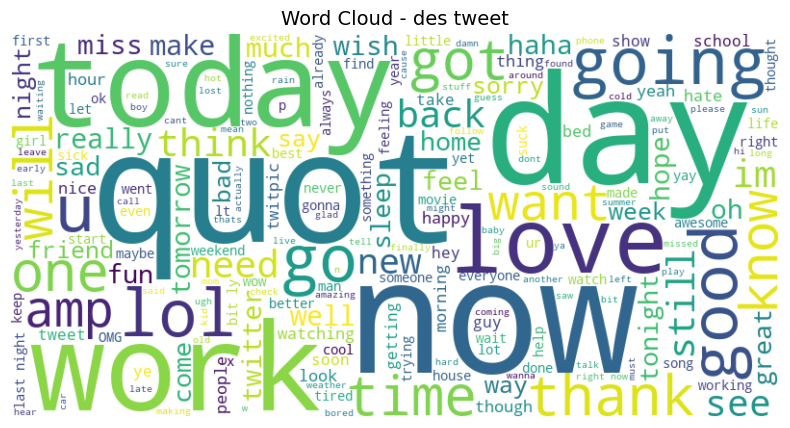

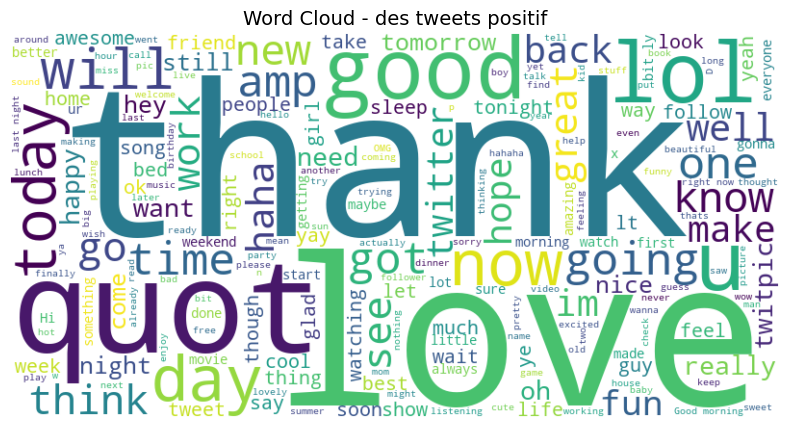

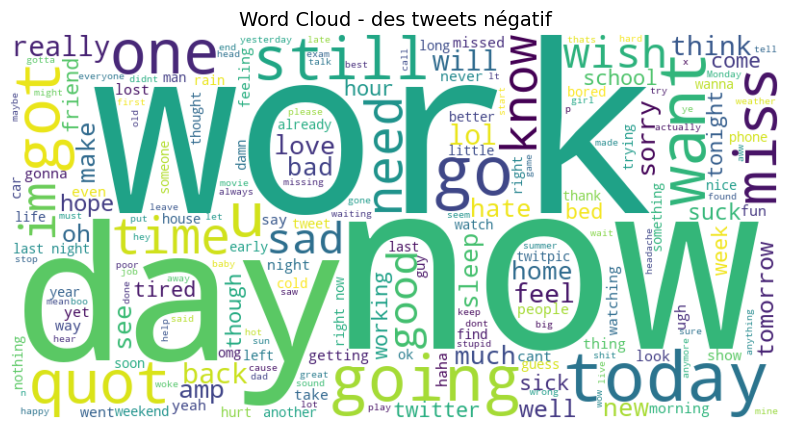

In [33]:
# Word cloud pour chaque type de sentiments
wordcloud(df_tweets["text"], "Word Cloud - des tweet")
wordcloud(tweets_positifs["text"], "Word Cloud - des tweets positif")
wordcloud(tweets_negatifs["text"], "Word Cloud - des tweets négatif")

In [34]:
df_tweets["clean_text"] = df_tweets["text"].apply(clean_text)
df_tweets

,target,id,date,flag,user,text,clean_text
0,1,2175633751,Mon Jun 15 01:32:47 PDT 2009,NO_QUERY,Nessa2813,Listening/singing along to Taylor Swift while ...,listening singing along taylor swift dishes
1,1,1831959940,Sun May 17 19:51:47 PDT 2009,NO_QUERY,chopsoi,best sentence ever... &quot; i wish i'd been b...,best sentence ever quot wish born pampered pan...
2,1,1833823364,Mon May 18 00:35:05 PDT 2009,NO_QUERY,tigeladakawaii,Thanks @ttimechitchat ? http://blip.fm/~6im45,thanks
3,1,2015231983,Wed Jun 03 04:05:19 PDT 2009,NO_QUERY,dit53,"Good game so far , let's see what the second h...",good game far let see second half brings
4,1,1678605865,Sat May 02 07:13:11 PDT 2009,NO_QUERY,binilvarghese,It's official now ! ! ! Scary yet feels good,official scary yet feels good
...,...,...,...,...,...,...,...
31995,0,2213662162,Wed Jun 17 15:40:32 PDT 2009,NO_QUERY,MaxxAzria,my tummy hurts and i still have to do my h.w....,tummy hurts still h w katy perry waking vegas ...
31996,0,2329173512,Thu Jun 25 10:26:13 PDT 2009,NO_QUERY,FirstLadyCfrank,"@houstonbeauty yea,not til September",yea til september
31997,0,2177497240,Mon Jun 15 06:12:37 PDT 2009,NO_QUERY,dohtay,Have to go to school today Need extra help in...,go school today need extra help french exam to...
31998,0,2325621402,Thu Jun 25 05:47:01 PDT 2009,NO_QUERY,Shameez,My boys is never staying at home again.Last ti...,boys never staying home last time internet mod...


In [35]:
"""vectorizer = TfidfVectorizer()

features = vectorizer.fit_transform(df_tweets["clean_text"])

features = features.toarray()

print("Dimenstion de la matrice :", features.shape)"""

'vectorizer = TfidfVectorizer()\n\nfeatures = vectorizer.fit_transform(df_tweets["clean_text"])\n\nfeatures = features.toarray()\n\nprint("Dimenstion de la matrice :", features.shape)'

In [36]:
"""X_train, X_temp, y_train, y_temp = train_test_split(features, df_tweets["target"], test_size = 0.2, stratify = df_tweets["target"], random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)"""

'X_train, X_temp, y_train, y_temp = train_test_split(features, df_tweets["target"], test_size = 0.2, stratify = df_tweets["target"], random_state=77)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)'

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Découpage des données brutes
X_temp, X_test, y_temp, y_test = train_test_split(df_tweets["clean_text"], df_tweets["target"], test_size=0.2, stratify=df_tweets["target"], random_state=77)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=77)

# Transformation TF-IDF
vectorizer = TfidfVectorizer()

# Apprentissage du vocabulaire sur l'ensemble d'entraînement uniquement
X_train_vec = vectorizer.fit_transform(X_train)

# Transformation des ensembles de validation et de test avec le vocabulaire appris
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)


## Modèles simple

### Regression Logistique

In [38]:
train_evaluate_simple_model("LinearRegression", LogisticRegression(), X_train_vec, y_train, X_val_vec, y_val)

2025/02/10 13:24:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/0/runs/e246182a94a74757b7f48f1e4765a314
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


### RandomForest

In [39]:
train_evaluate_simple_model("RandomForest", RandomForestClassifier(), X_train_vec, y_train, X_val_vec, y_val)

2025/02/10 13:25:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/0/runs/7c3a0ecb3ff6453dac6116b639b2dfca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


### XGBoost

In [40]:
train_evaluate_simple_model("XGBoost", XGBClassifier(), X_train_vec, y_train, X_val_vec, y_val)

2025/02/10 13:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/0/runs/3add86bdd2ec43dbbfec359382b185ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


## Modèle Avancé

### Préparation des données pour Glove

In [41]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
maxlen = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding="post", truncating="post")

# Charger l'embeddings de GloVe
embeddings_index = {}
with open("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, 200)) # 200 Dimension des vecteurs Glove (25, 50 et 100 possible)
for word, i in tokenizer.word_index.items():
    if i < 32000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Glove

2025/02/10 13:26:21 INFO mlflow.tracking.fluent: Experiment with name 'Neurones' does not exist. Creating a new experiment.


Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6484 - loss: 0.6232
Epoch 1: val_loss improved from inf to 0.54172, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6487 - loss: 0.6230 - val_accuracy: 0.7342 - val_loss: 0.5417
Epoch 2/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7269 - loss: 0.5359
Epoch 2: val_loss improved from 0.54172 to 0.52635, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7269 - loss: 0.5359 - val_accuracy: 0.7348 - val_loss: 0.5263
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7574 - loss: 0.4891
Epoch 3: val_loss improved from 0.52635 to 0.50744, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7574 - loss: 0.4891 - val_accuracy: 0.7472 - val_loss: 0.5074
Epoch 4/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7979 - loss: 0.4387
Epoch 4: val_loss impro

2025/02/10 13:28:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7517


2025/02/10 13:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step

Test Metrics:
Accuracy: 0.7135937213897705
Recall: 0.75390625
F1 Score: 0.753890621814144
AUC: 0.8346633789062501
Specificity: 0.761875
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step

Validation Metrics:
Accuracy: 0.7517187595367432
Recall: 0.75171875
F1 Score: 0.7517113243743252
AUC: 0.833098779296875
Specificity: 0.7571875


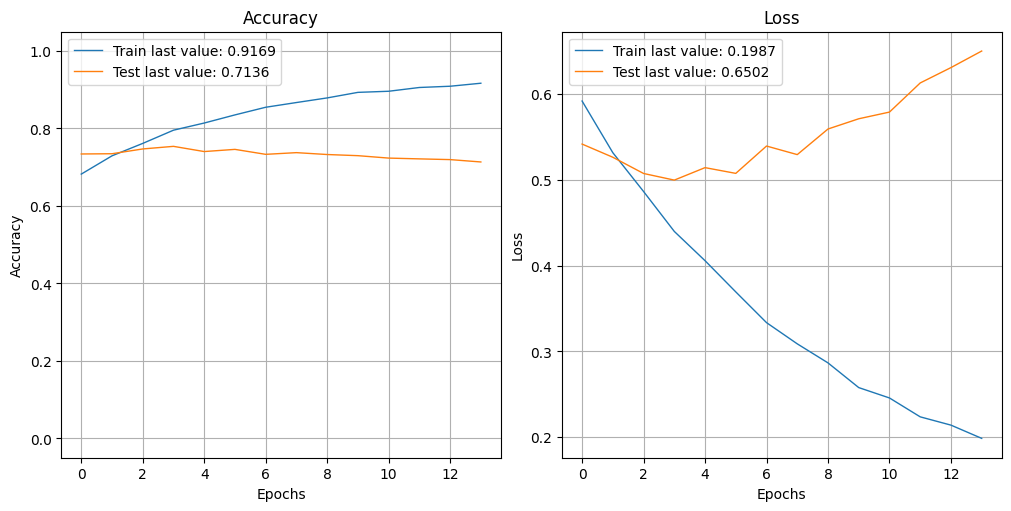

🏃 View run GloVe at: http://127.0.0.1:5000/#/experiments/2/runs/487f6f02828148c3afc9f2467fc48f1b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [42]:
embedding_layer = Embedding(input_dim=50000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### Glove + LSTM

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6875 - loss: 0.5830
Epoch 1: val_loss improved from inf to 0.50708, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6877 - loss: 0.5829 - val_accuracy: 0.7473 - val_loss: 0.5071
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7988 - loss: 0.4368
Epoch 2: val_loss improved from 0.50708 to 0.49123, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.7988 - loss: 0.4368 - val_accuracy: 0.7588 - val_loss: 0.4912
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8533 - loss: 0.3480
Epoch 3: val_loss did not improve from 0.49123
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8533 - loss: 0.3480 - val_accuracy: 0.7481 - val_loss: 0.5480
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8939 - loss: 0.2566
Epoch 4: val_loss did not improve from 0.49123
300/300 ━━━━━━━━━━━

2025/02/10 13:34:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7619


2025/02/10 13:34:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test Metrics:
Accuracy: 0.6990625262260437
Recall: 0.75875
F1 Score: 0.7586679612473732
AUC: 0.8420147949218749
Specificity: 0.7403125
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Validation Metrics:
Accuracy: 0.7618749737739563
Recall: 0.761875
F1 Score: 0.7618339721803639
AUC: 0.8464354980468749
Specificity: 0.74875


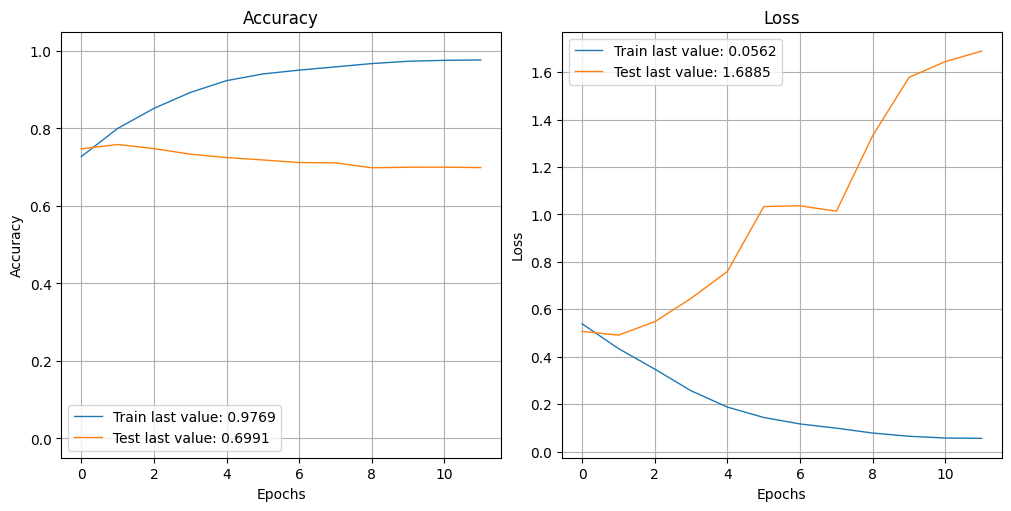

🏃 View run GloVe_LSTM at: http://127.0.0.1:5000/#/experiments/2/runs/4424f85c814c42178fc59f294fe249b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [44]:
embedding_layer = Embedding(input_dim=50000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe_LSTM", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### Glove + GRU

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6793 - loss: 0.5846
Epoch 1: val_loss improved from inf to 0.49289, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6794 - loss: 0.5845 - val_accuracy: 0.7592 - val_loss: 0.4929
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7996 - loss: 0.4354
Epoch 2: val_loss improved from 0.49289 to 0.49243, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.7996 - loss: 0.4354 - val_accuracy: 0.7644 - val_loss: 0.4924
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8594 - loss: 0.3304
Epoch 3: val_loss did not improve from 0.49243
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8594 - loss: 0.3304 - val_accuracy: 0.7458 - val_loss: 0.5421
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9097 - loss: 0.2267
Epoch 4: val_loss did not improve from 0.49243
300/300 ━━━━━━━━━━━

2025/02/10 13:38:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7625


2025/02/10 13:38:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test Metrics:
Accuracy: 0.6956250071525574
Recall: 0.764375
F1 Score: 0.7643381778402875
AUC: 0.8442248046875
Specificity: 0.751875
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Validation Metrics:
Accuracy: 0.762499988079071
Recall: 0.7625
F1 Score: 0.7624804927826591
AUC: 0.8480380371093749
Specificity: 0.7534375


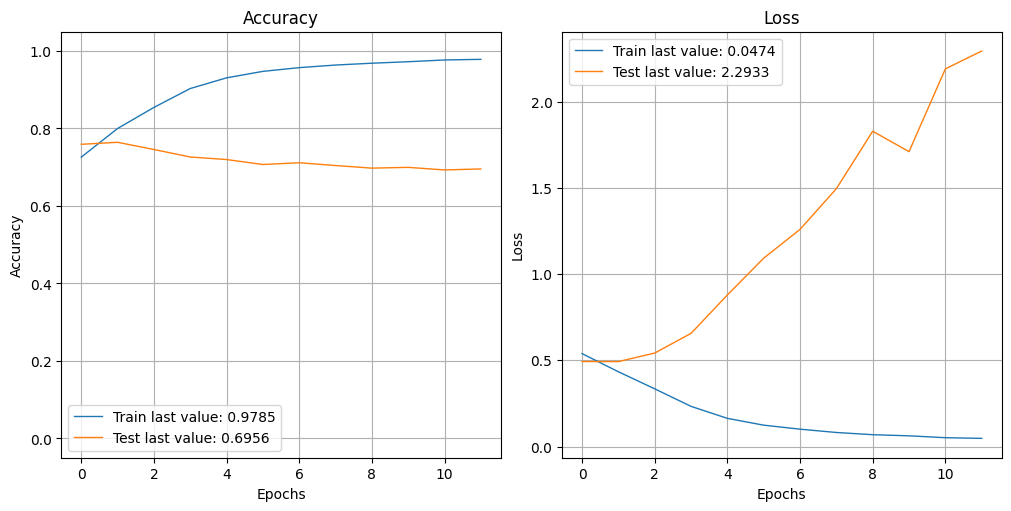

🏃 View run GloVe_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/8f43598421444199b453984be240eb1b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [46]:
embedding_layer = Embedding(input_dim=50000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe_GRU", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

### Préparation des données pour FastText

In [47]:
# Charger les vecteurs FastText
fasttext_path = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/cc.en.300.vec"
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)

# Préparer l'index des embeddings
embeddings_index = {}
for word in fasttext_model.index_to_key:
    embeddings_index[word] = fasttext_model[word]

In [48]:
# Préparation de l'embedding
embedding_dim = 300  # Dimension des vecteurs FastText
embedding_matrix = np.zeros((32000, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 32000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### FastText

Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6174 - loss: 0.6456
Epoch 1: val_loss improved from inf to 0.54048, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6177 - loss: 0.6453 - val_accuracy: 0.7242 - val_loss: 0.5405
Epoch 2/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7761 - loss: 0.4757
Epoch 2: val_loss improved from 0.54048 to 0.52062, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7761 - loss: 0.4757 - val_accuracy: 0.7408 - val_loss: 0.5206
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8283 - loss: 0.3866
Epoch 3: val_loss did not improve from 0.52062
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8283 - loss: 0.3866 - val_accuracy: 0.7344 - val_loss: 0.5265
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8722 - loss: 0.3018
Epoch 4: val_loss did not improve from 0.52062
300/300 ━━━━━━━━━━━━━━

2025/02/10 13:47:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7386


2025/02/10 13:47:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step

Test Metrics:
Accuracy: 0.6937500238418579
Recall: 0.74078125
F1 Score: 0.7398593193029623
AUC: 0.819785205078125
Specificity: 0.68125
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step

Validation Metrics:
Accuracy: 0.7385937571525574
Recall: 0.73859375
F1 Score: 0.7378319200263951
AUC: 0.8215615234375
Specificity: 0.6846875


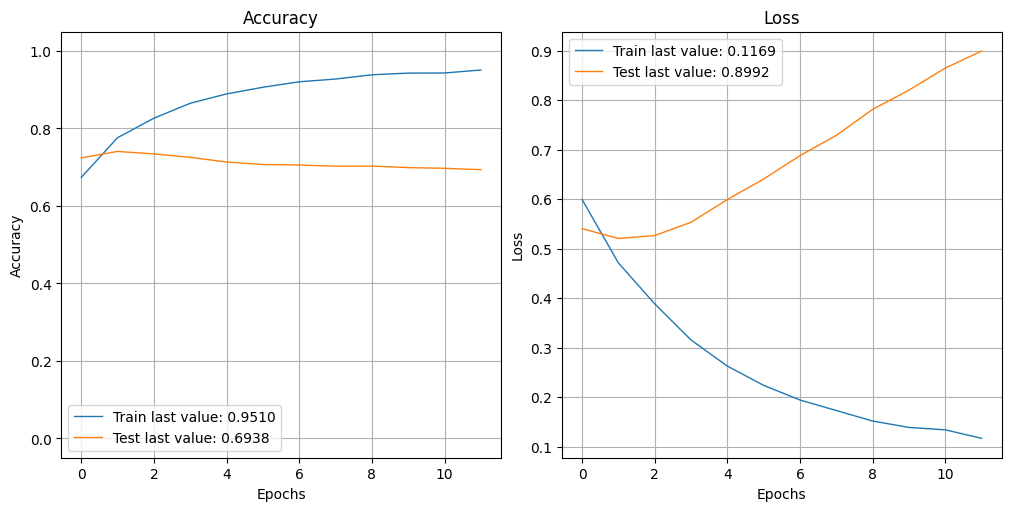

🏃 View run FastText at: http://127.0.0.1:5000/#/experiments/2/runs/79630501d2b44816802cde038b7567be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [49]:
embedding_layer = Embedding(input_dim=32000, output_dim=embedding_dim, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### FastText + LSTM

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6553 - loss: 0.6091
Epoch 1: val_loss improved from inf to 0.51867, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.6555 - loss: 0.6089 - val_accuracy: 0.7480 - val_loss: 0.5187
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8303 - loss: 0.3940
Epoch 2: val_loss did not improve from 0.51867
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.8302 - loss: 0.3941 - val_accuracy: 0.7419 - val_loss: 0.5336
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8867 - loss: 0.2735
Epoch 3: val_loss did not improve from 0.51867
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8867 - loss: 0.2735 - val_accuracy: 0.7211 - val_loss: 0.6283
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9224 - loss: 0.1856
Epoch 4: val_loss did not improve from 0.51867
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9224 - l

2025/02/10 13:51:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7436


2025/02/10 13:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Test Metrics:
Accuracy: 0.6967187523841858
Recall: 0.74796875
F1 Score: 0.7478532093966593
AUC: 0.82453740234375
Specificity: 0.769375
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Validation Metrics:
Accuracy: 0.7435937523841858
Recall: 0.74359375
F1 Score: 0.7434620676262657
AUC: 0.8293690429687499
Specificity: 0.76625


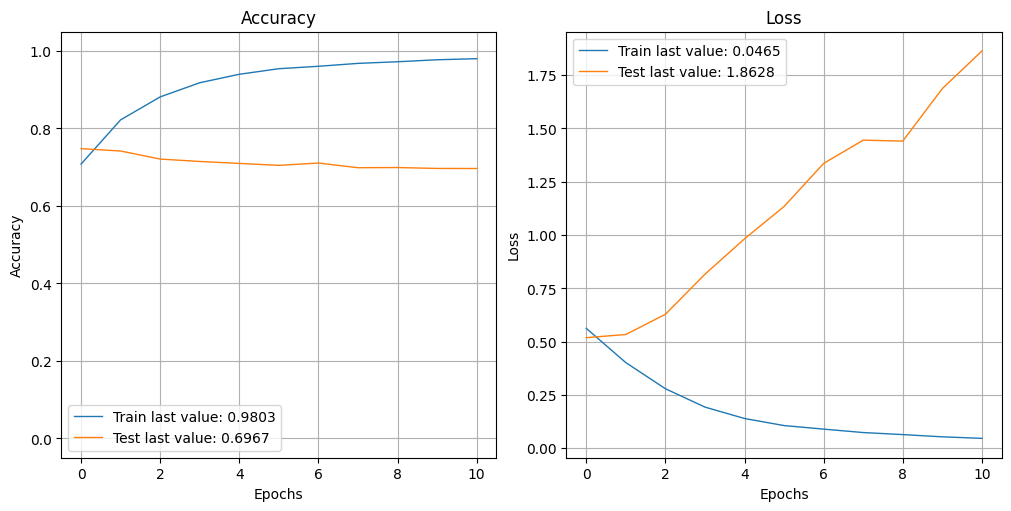

🏃 View run FastText_LSTM at: http://127.0.0.1:5000/#/experiments/2/runs/fab78b80eb86498a96aa21fd275e87f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [50]:
embedding_layer = Embedding(input_dim=32000, output_dim=300, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText_LSTM", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### FastText + GRU

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6538 - loss: 0.6129
Epoch 1: val_loss improved from inf to 0.51654, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.6540 - loss: 0.6128 - val_accuracy: 0.7484 - val_loss: 0.5165
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8222 - loss: 0.4000
Epoch 2: val_loss did not improve from 0.51654
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.8222 - loss: 0.4000 - val_accuracy: 0.7362 - val_loss: 0.5821
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8966 - loss: 0.2576
Epoch 3: val_loss did not improve from 0.51654
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8965 - loss: 0.2576 - val_accuracy: 0.7203 - val_loss: 0.6736
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9347 - loss: 0.1650
Epoch 4: val_loss did not improve from 0.51654
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9346 - l

2025/02/10 13:56:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7478


2025/02/10 13:56:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Test Metrics:
Accuracy: 0.6848437786102295
Recall: 0.7484375
F1 Score: 0.7484366155974768
AUC: 0.823862353515625
Specificity: 0.7465625
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Validation Metrics:
Accuracy: 0.7478125095367432
Recall: 0.7478125
F1 Score: 0.7478069586489937
AUC: 0.8317953125000002
Specificity: 0.7525


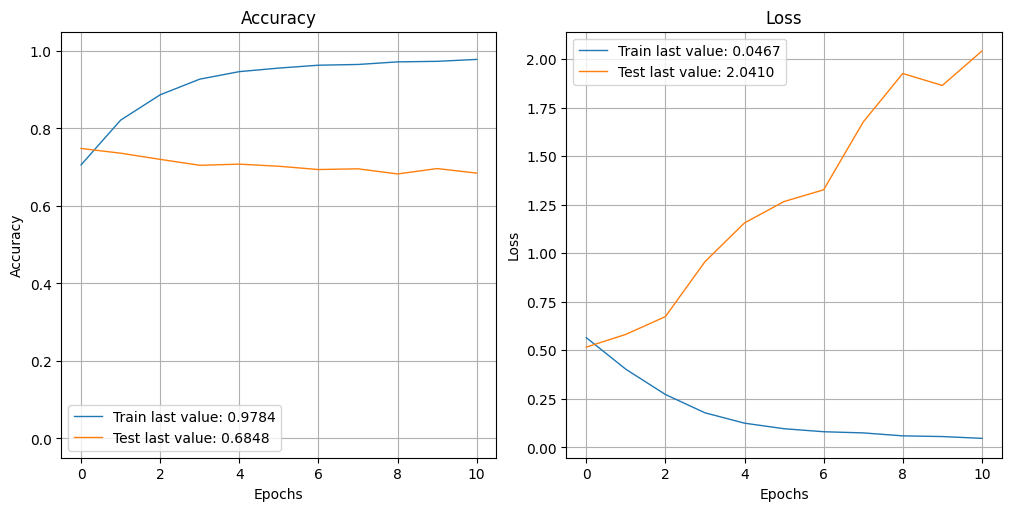

🏃 View run FastText_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/2b8f3ccf8632437db5409f992cbcf579
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [51]:
embedding_layer = Embedding(input_dim=32000, output_dim=300, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText_GRU", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

### Préparation des données pour USE

In [57]:
"""use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

X_train_embeddings = use_model(X_train)
X_test_embeddings = use_model(X_test)
X_val_embeddings = use_model(X_val)"""

'use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")\n\nX_train_embeddings = use_model(X_train)\nX_test_embeddings = use_model(X_test)\nX_val_embeddings = use_model(X_val)'

In [56]:
use_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

X_train_embeddings = use_model(X_train)
X_test_embeddings = use_model(X_test)
X_val_embeddings = use_model(X_val)

#### USE

Epoch 1/50


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


276/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6841 - loss: 0.6019
Epoch 1: val_loss improved from inf to 0.51694, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6871 - loss: 0.5982 - val_accuracy: 0.7447 - val_loss: 0.5169
Epoch 2/50
289/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7473 - loss: 0.5150
Epoch 2: val_loss improved from 0.51694 to 0.50966, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7472 - loss: 0.5150 - val_accuracy: 0.7502 - val_loss: 0.5097
Epoch 3/50
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7591 - loss: 0.4924
Epoch 3: val_loss improved from 0.50966 to 0.50458, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7591 - loss: 0.4925 - val_accuracy: 0.7559 - val_loss: 0.5046
Epoch 4/50
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7762 - loss: 0.4736
Epoch 4: val_loss improved from 0.50458 t

2025/02/10 14:05:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


2025/02/10 14:06:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step

Test Metrics:
Accuracy: 0.7265625
Recall: 0.7521875
F1 Score: 0.7521778194460721
AUC: 0.8316873046874999
Specificity: 0.7459375
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step

Validation Metrics:
Accuracy: 0.7540624737739563
Recall: 0.7540625
F1 Score: 0.754037903790379
AUC: 0.8333235839843749
Specificity: 0.7440625


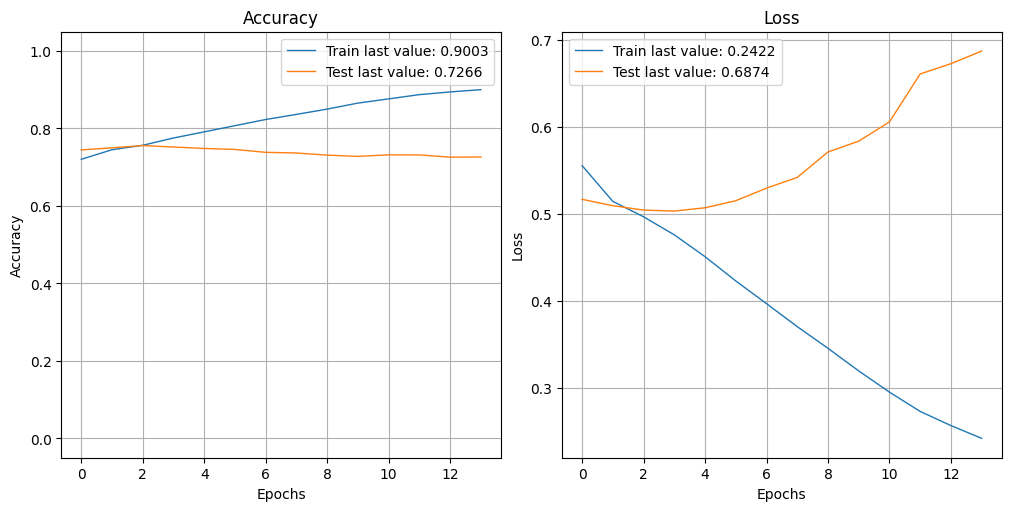

🏃 View run USE at: http://127.0.0.1:5000/#/experiments/2/runs/a61a682e1d614607beea0af5f88308ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [58]:
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(512,)))
model.add(Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

train_evaluate_neural_model("Neurones", "USE", model, X_train_embeddings, y_train, X_test_embeddings, y_test, X_val_embeddings, y_val)

* USE diffère des embeddings classiques comme GloVe ou FastText.
* Contrairement à eux qui génèrent des vecteurs mot par mot, USE génère un vecteur d'encodage pour des phrases ou des textes entiers.
* Cela simplifie l'architecture du modèle et élimine la nécessité d'utiliser une couche d'embedding.

## BERT

In [59]:
max_length = 64
batch_size = 10
model_type = "bert-base-uncased"
model = TFAutoModel.from_pretrained(model_type)
sentences = df_tweets["clean_text"].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [61]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                        max_length, batch_size, mode="HF")

1/1 [==============================] - 0s 134ms/step
temps traitement :  2520.0


In [62]:
# Utilisation des features de BERT
X_train_bert = features_bert[y_train.index]
X_test_bert = features_bert[y_test.index]
X_val_bert = features_bert[y_val.index]

#### BERT + LSTM

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
265/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6519 - loss: 0.6140
Epoch 1: val_loss improved from inf to 0.54616, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6568 - loss: 0.6097 - val_accuracy: 0.7144 - val_loss: 0.5462
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7269 - loss: 0.5387
Epoch 2: val_loss improved from 0.54616 to 0.54174, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7269 - loss: 0.5387 - val_accuracy: 0.7237 - val_loss: 0.5417
Epoch 3/50
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7296 - loss: 0.5349
Epoch 3: val_loss improved from 0.54174 to 0.53394, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7297 - loss: 0.5348 - val_accuracy: 0.7316 - val_loss: 0.5339
Epoch 4/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7430 - loss: 0.5164
Epoch 4: val_loss improved fro

2025/02/10 15:34:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.73


2025/02/10 15:34:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step

Test Metrics:
Accuracy: 0.6998437643051147
Recall: 0.72796875
F1 Score: 0.7279615173362398
AUC: 0.805304833984375
Specificity: 0.7228125
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step

Validation Metrics:
Accuracy: 0.7285937666893005
Recall: 0.72859375
F1 Score: 0.7285913579462944
AUC: 0.802046337890625
Specificity: 0.725625


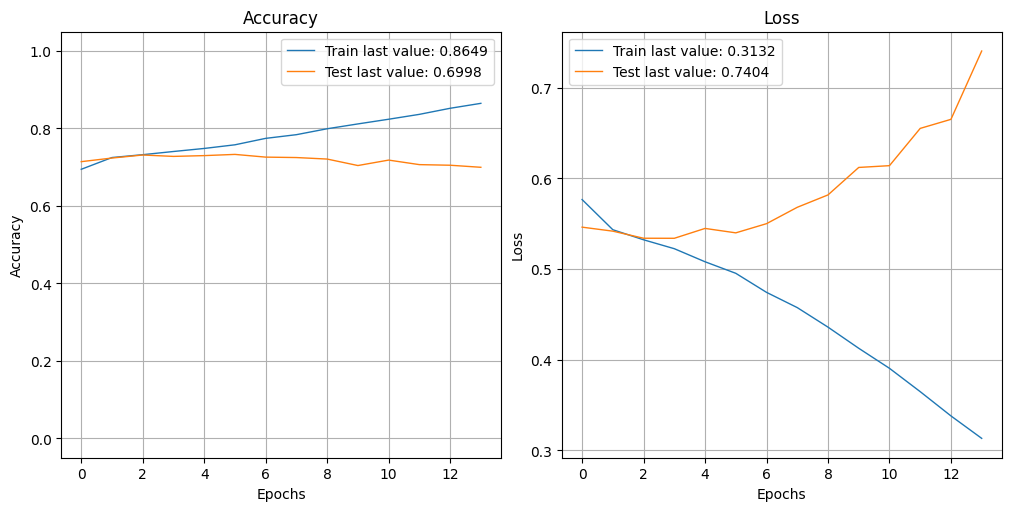

🏃 View run BERT_LSDM at: http://127.0.0.1:5000/#/experiments/2/runs/8eeea2831201434696612855b7aa3646
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [63]:
input_dim = X_train_bert.shape[1]
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=input_dim))
model.add(Reshape((1, 128)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Appel de la fonction avec le modèle et les données
train_evaluate_BERT_model("Neurones", "BERT_LSDM", model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

#### BERT + GRU

Epoch 1/50


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


289/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6626 - loss: 0.6033
Epoch 1: val_loss improved from inf to 0.54455, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6639 - loss: 0.6023 - val_accuracy: 0.7220 - val_loss: 0.5446
Epoch 2/50
270/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7270 - loss: 0.5401
Epoch 2: val_loss did not improve from 0.54455
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7266 - loss: 0.5407 - val_accuracy: 0.7228 - val_loss: 0.5470
Epoch 3/50
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7358 - loss: 0.5319
Epoch 3: val_loss improved from 0.54455 to 0.54173, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7358 - loss: 0.5319 - val_accuracy: 0.7252 - val_loss: 0.5417
Epoch 4/50
278/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7489 - loss: 0.5145
Epoch 4: val_loss did not improve from 0.54173
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025/02/10 15:35:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.73


2025/02/10 15:35:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step

Test Metrics:
Accuracy: 0.6967187523841858
Recall: 0.7325
F1 Score: 0.7324715489762533
AUC: 0.805452978515625
Specificity: 0.7428125
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step

Validation Metrics:
Accuracy: 0.7276562452316284
Recall: 0.72765625
F1 Score: 0.7276188441405833
AUC: 0.79853271484375
Specificity: 0.739375


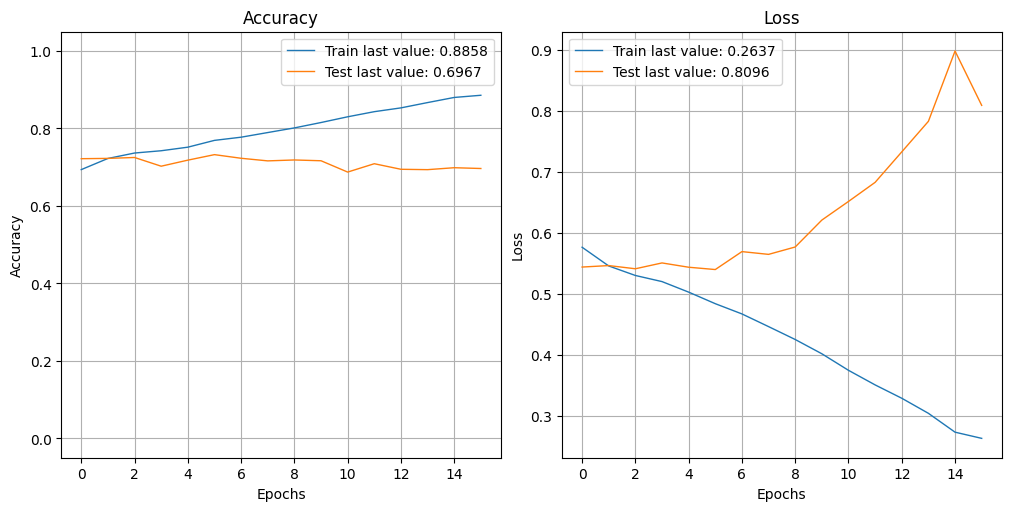

🏃 View run BERT_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/18489d92939344fd9e51ddb50a505241
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [64]:
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=input_dim))
model.add(Reshape((1, 128)))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Appel de la fonction avec le modèle et les données
train_evaluate_BERT_model("Neurones", "BERT_GRU", model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

# Test sur 128 000 tweets

## FastText + GRU

In [65]:
# Échantillonnage équilibré
df_positifs = data[data["target"] == 1].sample(n=64000, random_state=77)
df_negatifs = data[data["target"] == 0].sample(n=64000, random_state=77)

# Concaténation et mélange des données
df_model = pd.concat([df_positifs, df_negatifs]).sample(frac=1, random_state=77).reset_index(drop=True)

# Nettoyage des textes avec un pipeline avancé
df_model["clean_text"] = df_model["text"].apply(lambda x: process_text(x,
                                                                    rejoin=True,
                                                                    lemm_or_stemm="lem",
                                                                    force_is_alpha=True,
                                                                    include_stopwords=True))

# Séparation des données (entraînement, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(df_model["clean_text"], df_model["target"], test_size=0.2, stratify=df_model["target"], random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=77)

# Préparation des données avec un tokenizer
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

# Chargement et création des embeddings FastText
ft = fasttext.load_model("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/cc.en.300.bin")

embedding_dim = ft.get_dimension()
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = ft[word] if word in ft else None
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Construction du modèle avec GRU bidirectionnel
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Enregistrement avec MLflow
with mlflow.start_run(run_name="FastText + GRU Model"):
    # Enregistrement des hyperparamètres
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("gru_units", 128)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "binary_crossentropy")

    # Entraînement avec EarlyStopping
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Évaluation sur l'ensemble de test
    y_pred_prob = model.predict(X_test_pad, batch_size=64)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, batch_size=64)
    auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])

    # Enregistrement des métriques
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("auc", auc)

    # Enregistrement de la matrice de confusion
    np.save("confusion_matrix.npy", conf_matrix)
    mlflow.log_artifact("confusion_matrix.npy")

    # Enregistrement du modèle
    mlflow.keras.log_model(model, artifact_path="models")

    # Résultats dans la console
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_rep)

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │    15,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 15,000,000 (57.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 136s 84ms/step - accuracy: 0.7106 - loss: 0.5465 - val_accuracy: 0.8010 - val_loss: 0.4336
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 154s 96ms/step - accuracy: 0.8424 - loss: 0.3693 - val_accuracy: 0.7941 - val_loss: 0.4483
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 150s 93ms/step - accuracy: 0.8944 - loss: 0.2609 - val_accuracy: 0.7934 - val_loss: 0.5277
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 158s 98ms/step - accuracy: 0.9236 - loss: 0.1889 - val_accuracy: 0.7845 - val_loss: 0.5855
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8003 - loss: 0.4353


2025/02/10 15:50:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 15:50:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.4400, Test Accuracy: 0.7983, AUC: 0.8782

Confusion Matrix:
[[5087 1313]
 [1269 5131]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.79      0.80      6400
    Positive       0.80      0.80      0.80      6400

    accuracy                           0.80     12800
   macro avg       0.80      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800

🏃 View run FastText + GRU Model at: http://127.0.0.1:5000/#/experiments/2/runs/38ee1e29554f4cf89eaf22d68cfc9688
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [66]:
"""# Sauvegarde du modèle
model_path = "FastText_gru_model.keras"
model.save(model_path)"""

'# Sauvegarde du modèle\nmodel_path = "FastText_gru_model.keras"\nmodel.save(model_path)'

## Glove + GRU

In [67]:
# Chemin du fichier GloVe
glove_file = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt"

# Chargement des embeddings GloVe
embedding_index = {}
with open(glove_file, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Création de la matrice d'embedding
embedding_dim = 200  # Les dimensions de GloVe (par exemple, 200d)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [68]:
# Construction du modèle avec GRU bidirectionnel et GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,000,000 (38.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,000,000 (38.15 MB)

In [69]:
with mlflow.start_run(run_name="GloVe + GRU Model"):
    # Enregistrement des hyperparamètres
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("gru_units", 128)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "binary_crossentropy")

    # Entraînement du modèle
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Évaluation du modèle
    y_pred_prob = model.predict(X_test_pad, batch_size=64)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, batch_size=64)
    auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])

    # Enregistrement des métriques
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("auc", auc)

    # Enregistrement de la matrice de confusion
    np.save("confusion_matrix.npy", conf_matrix)
    mlflow.log_artifact("confusion_matrix.npy")

    # Enregistrement du modèle avec MLflow
    mlflow.keras.log_model(model, artifact_path="models")

    # Affichage des résultats
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_rep)

Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - accuracy: 0.7216 - loss: 0.5436 - val_accuracy: 0.7910 - val_loss: 0.4446
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 90s 56ms/step - accuracy: 0.7940 - loss: 0.4506 - val_accuracy: 0.8021 - val_loss: 0.4256
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.8029 - loss: 0.4334 - val_accuracy: 0.8093 - val_loss: 0.4183
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 86s 54ms/step - accuracy: 0.8165 - loss: 0.4106 - val_accuracy: 0.8006 - val_loss: 0.4279
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.8235 - loss: 0.3950 - val_accuracy: 0.8116 - val_loss: 0.4130
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 88s 55ms/step - accuracy: 0.8345 - loss: 0.3740 - val_accuracy: 0.8069 - val_loss: 0.4193
Epoch 7/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.8469 - loss: 0.3470 - val_accuracy: 0.8066 - val_loss: 0.4362
Epoch 8/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 88s 55ms/step - accuracy: 0.8603 -

2025/02/10 16:04:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 16:04:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.4253, Test Accuracy: 0.8049, AUC: 0.8875

Confusion Matrix:
[[4954 1446]
 [1051 5349]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.77      0.80      6400
    Positive       0.79      0.84      0.81      6400

    accuracy                           0.80     12800
   macro avg       0.81      0.80      0.80     12800
weighted avg       0.81      0.80      0.80     12800

🏃 View run GloVe + GRU Model at: http://127.0.0.1:5000/#/experiments/2/runs/76f5f3156ff54faa9da75cd488c5ca60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# Sauvegarde des ressources

## Le modèle

In [70]:
# Sauvegarde du modèle
model_path = r"C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models\Glove_gru_model.keras"
model.save(model_path)

In [ ]:
"""# Sauvegarde du modèle
model_path = "Glove_gru_model.keras"
model.save(model_path)"""

## Le Tokeniser

In [72]:
import pickle

# Définir le chemin de sauvegarde
tokenizer_path = r"C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models\tokenizer.pickle"

# Sauvegarde du tokenizer
with open(tokenizer_path, "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
"""import pickle

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

## La longueur maximale des sequences

In [74]:
import pickle

# Calcul de la longueur maximale
max_len = max(len(seq) for seq in X_train_seq)

# Définir le chemin de sauvegarde
maxlen_path = r"C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models\maxlen.pickle"

# Sauvegarde de max_len
with open(maxlen_path, "wb") as handle:
    pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
"""max_len = max(len(seq) for seq in X_train_seq)  # Calcul de la longueur maximale
with open("maxlen.pickle", "wb") as handle:
    pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

## Vérification des sauvegardes

In [76]:
import os

# Définir le chemin du dossier contenant les fichiers
model_dir = r"C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models"

# Liste des fichiers requis
required_files = ["Glove_gru_model.keras", "tokenizer.pickle", "maxlen.pickle"]

# Vérifier l'existence des fichiers dans le dossier spécifié
for file in required_files:
    file_path = os.path.join(model_dir, file)
    if os.path.exists(file_path):
        print(f"✅ {file} est enregistré dans {model_dir}.")
    else:
        print(f"❌ {file} est manquant dans {model_dir}.")

✅ Glove_gru_model.keras est enregistré dans C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models.
✅ tokenizer.pickle est enregistré dans C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models.
✅ maxlen.pickle est enregistré dans C:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\OC_AI_Engineer_P7\models.


In [ ]:
"""import os

required_files = ["Glove_gru_model.keras", "tokenizer.pickle", "maxlen.pickle"]
for file in required_files:
    if os.path.exists(file):
        print(f"✅ {file} est enregistré.")
    else:
        print(f"❌ {file} est manquant.")"""

✅ Glove_gru_model.keras est enregistré.
✅ tokenizer.pickle est enregistré.
✅ maxlen.pickle est enregistré.


In [59]:
finish_notebook = time.time()
elapsed_time = finish_notebook - start_notebook

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Temps total d'exécution du notebook : {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Temps total d'exécution du notebook : 1h 36m 5.31s


# Accès au site de prédiction

- Streamlit local : streamlit run P7_Streamlit.py
- API (invit command) : uvicorn main:app --host 0.0.0.0 --port 8000
http://127.0.0.1:8000/docs